contact author: Aaron Meisner

last verified to run: 2023 Nov 16

LSST pipelines version:  `w_2023_37`

container size: small

# compute metrics for RSP Butler user collections

In [1]:
import numpy as np
from lsst.daf.butler import Butler
import matplotlib.pyplot as plt
import os
import time
import pandas
from collections import Counter

note
====

Toggle the `anonymize` variable in the following code cell to turn on/off anonymization of user names throughout this notebook.

In [2]:
anonymize = True
butler_repo = 'dp02'

In [3]:
print("running RSP Butler user collection analysis on date = ", time.strftime("%Y-%m-%d"))

running RSP Butler user collection analysis on date =  2023-11-16


In [4]:
butler = Butler(butler_repo)

colls = butler.registry.queryCollections('*u/*')
colls.sort()
print("total number of candidate RSP Butler user collections found = ", len(colls))

total number of candidate RSP Butler user collections found =  2840


In [5]:
colls = np.array(colls)
# remove mobu test runs (https://github.com/lsst-sqre/mobu/)
keep = [line.find('mobu') == -1 for line in colls]
colls = colls[keep]
print("total number of RSP Butler user collections retained = ", len(colls))

total number of RSP Butler user collections retained =  981


In [6]:
# remove "parent" directories

delete = np.zeros(len(colls), dtype=bool)
for line in colls:
    for i,o in enumerate(colls):
        if o == line:
            continue
        if line.find(o) != -1:
            delete[i] = True

In [7]:
colls = colls[np.logical_not(delete)]

In [8]:
unames = []

for i,line in enumerate(colls):
    p = line.find('u/')
    #print(i)
    assert(p >= 0)
    colls[i] = line[(p+2):]
    tokens = colls[i].split('/')
    unames.append(tokens[0])

In [9]:
print('number of unique RSP dp02 Butler user collections = ', len(colls))

number of unique RSP dp02 Butler user collections =  724


In [10]:
unames = np.array(unames)
print('number of unique non-bot RSP user names with a dp02 Butler user collection = ', len(np.unique(unames)))

number of unique non-bot RSP user names with a dp02 Butler user collection =  67


In [11]:
print('average number of RSP dp02 Butler user collections per user name with at least one such collection = ', '{:.1f}'.format(float(len(colls))/len(np.unique(unames))))

average number of RSP dp02 Butler user collections per user name with at least one such collection =  10.8


In [12]:
if not anonymize:
    print("list of RSP user names with at least one Butler user collection on RSP:\n")
    print(np.unique(unames))

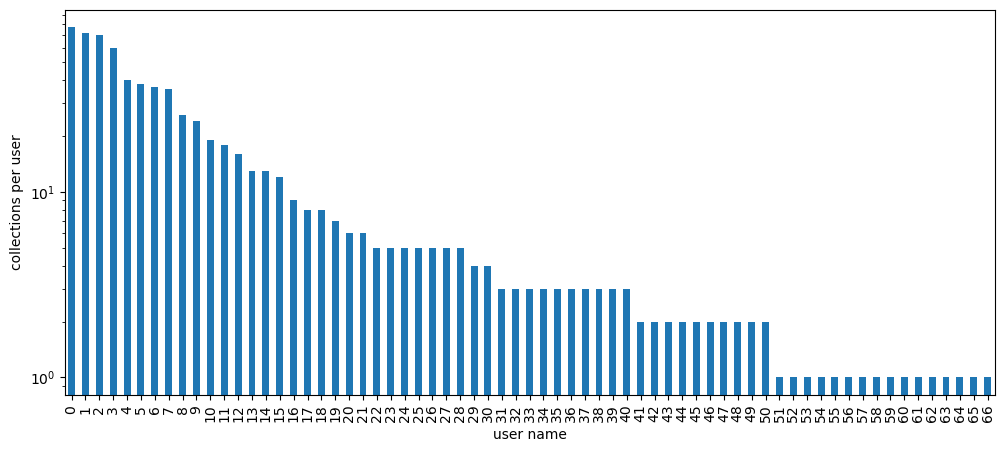

In [13]:
uname_counts = Counter(unames)
df = pandas.DataFrame.from_dict(uname_counts, orient='index', columns=['ncoll'])
df.sort_values(by='ncoll', ascending=False, inplace=True)
df
df.plot(kind='bar', use_index=(not anonymize), legend=False, figsize=(12, 5), logy=True, xlabel='user name', ylabel='collections per user')
_ = plt.xlabel('user name')

In [14]:
def is_timestamp(string):
    return (len(string) == 16) and (string[-1] == 'Z') and (string[0:2] == '20')

In [15]:
has_timestamp = np.zeros(len(colls), dtype=bool)
for i, line in enumerate(colls):
    has_timestamp[i] = is_timestamp(os.path.basename(line))

In [16]:
print("number of timestamp RSP Butler user collections = ", np.sum(has_timestamp))
print("number of non-timestamp RSP Butler user collections = ", np.sum(np.logical_not(has_timestamp)))

number of timestamp RSP Butler user collections =  670
number of non-timestamp RSP Butler user collections =  54


In [17]:
years = [os.path.basename(s)[0:4] for s in colls[has_timestamp]]

In [18]:
print("unique calendar years for timestamp Butler user collection directories:\n")
print(np.unique(years))

unique calendar years for timestamp Butler user collection directories:

['2021' '2022' '2023']


In [19]:
years = np.array(years, dtype=float)

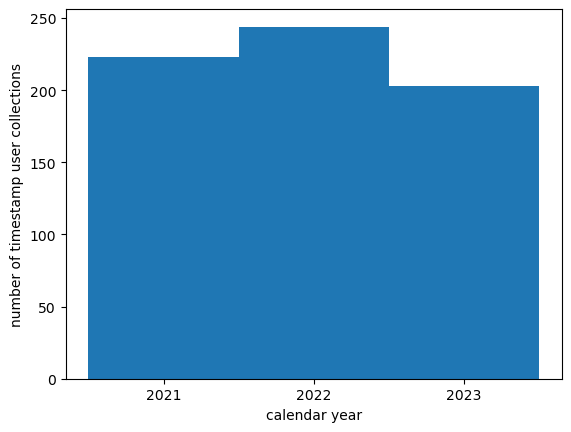

In [20]:
# could try making a version normalized to the amount of time in the current year that's actually passed

bins = np.arange(np.min(years)-0.5,np.max(years)+1.5,1)
plt.hist(years, bins=bins)
plt.xticks(np.unique(years))
plt.xlabel('calendar year')
_ = plt.ylabel('number of timestamp user collections')

In [21]:
# now make a list of search strings that identify DP0.2 tutorials that tell users to make output Butler user collections

# nb09a = DP0.2 notebook tutorial 09a
# nb09b = DP0.2 notebook tutorial 09b
    # note that this was only put into production a few days ago as of this writing !!!
    # previously nb09b did not persist any outputs (all in-memory)
# cl02a = DP0.2 command line tutorial 02, the part corresponding to notebook tutorial 09a
# cl02b = DP0.2 command line tutorial 02, the part corresponding to notebook tutorial 09b
    # note that this was only put into production a few days ago as of this writing !!!

collection_names_exact = {'nb09a' : 'custom_coadd_window1_test1',
                          'nb09b' : 'custom_coadd_window1_test1_nbdet',
                          'cl02a' : 'custom_coadd_window1_cl00',
                          'cl02b' : 'custom_coadd_window1_cl00_det'}

In [22]:
found_any = np.zeros(len(colls), dtype=bool)
for k in collection_names_exact.keys():
    found = np.array([line.find(collection_names_exact[k]) != -1 for line in colls])
    if k.find('a') != -1:
        discount = np.array([line.find(collection_names_exact[k.replace('a', 'b')]) != -1 for line in colls])
        found = np.logical_and(found, np.logical_not(discount))
        
    found_any = np.logical_or(found_any, found)
    print(k + ' : ', ' found ', np.sum(found), 'user collections from ', len(np.unique(unames[found])), ' unique users')

nb09a :   found  74 user collections from  24  unique users
nb09b :   found  6 user collections from  2  unique users
cl02a :   found  40 user collections from  5  unique users
cl02b :   found  4 user collections from  3  unique users


In [23]:
if not anonymize:
    print("list of unique user names with at least one Butler user collection matching that of a DP0.2 tutorial:\n")
    print(np.unique(unames[found_any]))

In [24]:
print("total number of RSP user collections arising from DP0.2 tutorials = ", np.sum(found_any))

total number of RSP user collections arising from DP0.2 tutorials =  124


In [25]:
print("number of unique RSP user names with at least one user collection matching that of a DP0.2 tutorial = ", len(np.unique(unames[found_any])))

number of unique RSP user names with at least one user collection matching that of a DP0.2 tutorial =  25


notes
=====
'$USER' shows up among the "user names", could imagine special-casing to remove that...